In [132]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# escalado
from sklearn.preprocessing import StandardScaler

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report


import pickle

import warnings
warnings.filterwarnings('ignore')

# Proyecto Árbol de decisión y Random Forest
## Análisis EDA

In [133]:
df = pd.read_csv("https://breathecode.herokuapp.com/asset/internal-link?id=930&path=diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [134]:
df.shape

(768, 9)

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [136]:
df.duplicated().sum()

np.int64(0)

In [137]:
# Renombrar las columnas

df.columns = df.columns.str.lower()
df.rename(columns={"bloodpressure": "blood_pressure",
                   "skinthickness": "skin_thickness",
                   "diabetespedigreefunction": "diabetes_pedigree_function"}, inplace = True)

In [138]:
df.describe()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Se observan valores que no resultan realistas para tratarse de datos médicos, como ceros o cifras inusualmente altas. Aunque algunos podrían corresponder a casos reales, estos valores probablemente no representan la distribución general de la población. El siguiente paso es analizar la distribución de cada variable y eliminar los valores atípicos más extremos

Criterios para la eliminación de outliers:

* pregnancies: Se mantiene el rango entre 0 y 13, considerando que existen varios registros en 12.
* glucose: Se mantiene el rango 50-200.
* blood_pressure: Se mantiene entre 50 y 120, eliminando registros con cifras poco realistas para pacientes adultos.
* skin_thickness: por el momento se conservan los valores en cero debido a su alta frecuencia, pero se eliminan los superiores a 80.
* insulin: igualmente se mantienen los ceros, pero se excluyen los valores por encima de 450.
* bmi: Se conserva el rango 10-60.


In [139]:
# Quitamos los outliers más destacables

outliers = df[
    (df["glucose"] < 50) | 
    (df["blood_pressure"] < 50) | 
    (df["skin_thickness"] > 80) | 
    (df["insulin"] > 450) | 
    (df["bmi"] < 10) | 
    (df["bmi"] > 60) |
    (df["pregnancies"] > 13)
]
outliers.shape

(83, 9)

In [140]:
df_filtrado = df.drop(outliers.index)

In [141]:
df.shape, df_filtrado.shape

((768, 9), (685, 9))

En total se han eliminado 83 registros clasificados como valores atípicos.

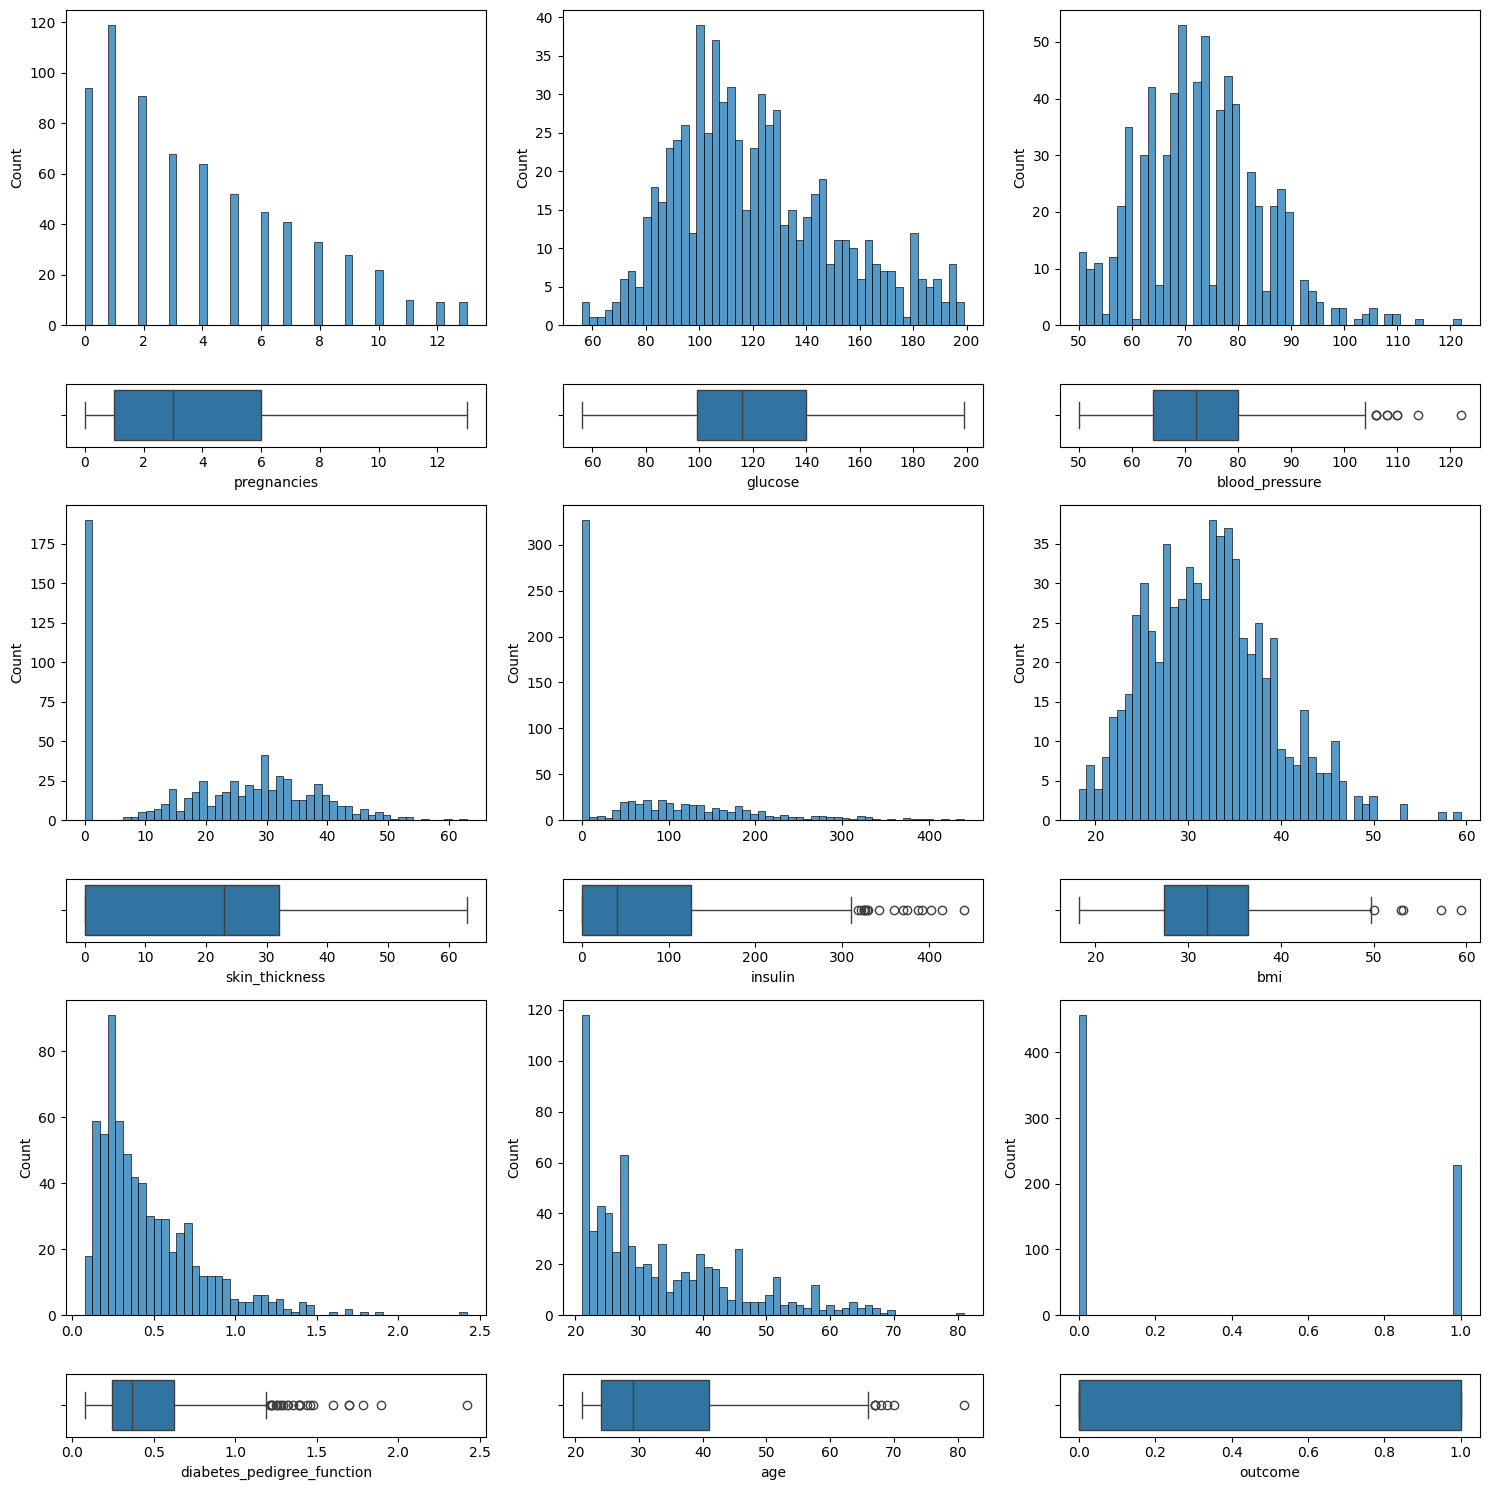

In [142]:
fig, axis = plt.subplots(6, 3, figsize = (15, 15), gridspec_kw={'height_ratios': [5, 1, 5, 1, 5, 1]})
# Crear una figura múltiple con histogramas y diagramas de caja
sns.histplot(ax = axis[0, 0], data = df_filtrado, x = "pregnancies", bins = 50).set(xlabel = None)
sns.boxplot(ax = axis[1, 0], data = df_filtrado, x = "pregnancies")

sns.histplot(ax = axis[0, 1], data = df_filtrado, x = "glucose", bins = 50).set(xlabel = None)
sns.boxplot(ax = axis[1, 1], data = df_filtrado, x = "glucose")

sns.histplot(ax = axis[0, 2], data = df_filtrado, x = "blood_pressure", bins = 50).set(xlabel = None)
sns.boxplot(ax = axis[1, 2], data = df_filtrado, x = "blood_pressure")

sns.histplot(ax = axis[2, 0], data = df_filtrado, x = "skin_thickness", bins = 50).set(xlabel = None)
sns.boxplot(ax = axis[3, 0], data = df_filtrado, x = "skin_thickness")

sns.histplot(ax = axis[2, 1], data = df_filtrado, x = "insulin", bins = 50).set(xlabel = None)
sns.boxplot(ax = axis[3, 1], data = df_filtrado, x = "insulin")

sns.histplot(ax = axis[2, 2], data = df_filtrado, x = "bmi", bins = 50).set(xlabel = None)
sns.boxplot(ax = axis[3, 2], data = df_filtrado, x = "bmi")

sns.histplot(ax = axis[4, 0], data = df_filtrado, x = "diabetes_pedigree_function", bins = 50).set(xlabel = None)
sns.boxplot(ax = axis[5, 0], data = df_filtrado, x = "diabetes_pedigree_function")

sns.histplot(ax = axis[4, 1], data = df_filtrado, x = "age", bins = 50).set(xlabel = None)
sns.boxplot(ax = axis[5, 1], data = df_filtrado, x = "age")

sns.histplot(ax = axis[4, 2], data = df_filtrado, x = "outcome", bins = 50).set(xlabel = None)
sns.boxplot(ax = axis[5, 2], data = df_filtrado, x = "outcome")

plt.tight_layout()

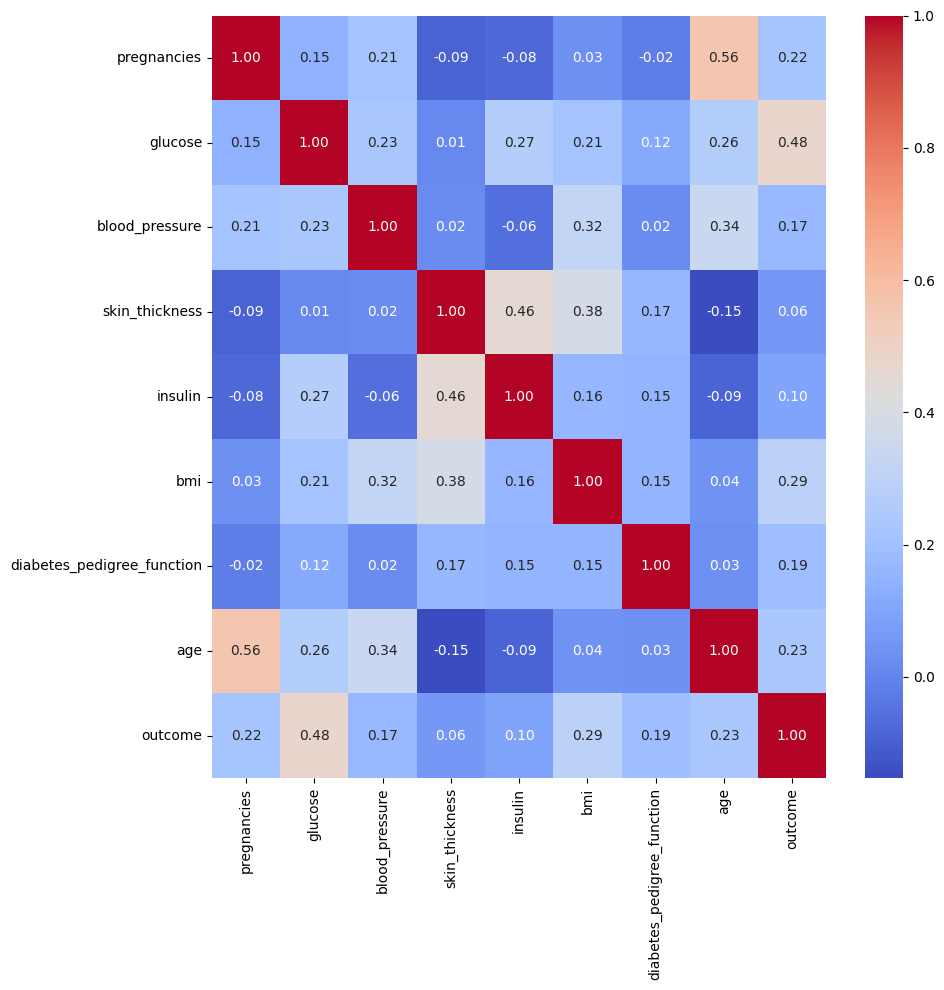

In [143]:
fig, axis = plt.subplots(figsize = (10, 10))

sns.heatmap(df_filtrado.corr(), annot = True, fmt = ".2f", cmap = "coolwarm")

plt.tight_layout()

plt.show()

Es probable que los valores mostrados en el mapa de correlaciones estén influenciados por la presencia de numerosos ceros en el Data set. 
Opté por imputar los ceros presentes en estas variables con valores aleatorios siguiendo una distribución normal

In [144]:
# Creamos un data set unicamente con los registros con valores faltantes

zeros = df_filtrado[
    (df["skin_thickness"] == 0) |
    (df["insulin"] == 0)
]
# Creamos un data set sin los registros con valores faltantes

df_sin_ceros = df_filtrado.drop(zeros.index)
df_sin_ceros.shape

(358, 9)

In [145]:
# Obtenemos la media de la variable sin ceros

mu_skin = df_sin_ceros["skin_thickness"].mean()
sigma_skin = df_sin_ceros["skin_thickness"].std()
mu_skin, sigma_skin

(np.float64(28.77094972067039), np.float64(10.47488899108798))

In [146]:
# contamos el numero de ceros para saber cuantos valores aleatorios generar

num_zeros_skin = (df_filtrado["skin_thickness"] == 0).sum()
num_zeros_skin

np.int64(190)

In [147]:
# Generamos los valores aleatorios y acotamos el min y max
np.random.seed(42)
random_values = np.random.normal(mu_skin, sigma_skin, num_zeros_skin)
random_values = np.clip(random_values, a_min=df_sin_ceros["skin_thickness"].min(), a_max=df_sin_ceros["skin_thickness"].max())
random_values

array([33.97397533, 27.32264651, 35.55541526, 44.7245184 , 26.31821911,
       26.31839109, 45.31302866, 36.80974332, 23.85325764, 34.45420595,
       23.91670083, 23.89248225, 31.30547766,  8.72955155, 10.70262691,
       22.88105027, 18.16165617, 32.06265565, 19.25949833, 13.97722523,
       44.12345788, 26.40596804, 29.47830017, 13.84687063, 23.06860111,
       29.93285153, 16.71441977, 32.70634476, 22.47932612, 25.71549007,
       22.46813975, 48.17335808, 28.62956779, 17.69154516, 37.38701637,
       15.98274801, 30.95877269,  8.24362271, 14.8583483 , 30.83304931,
       36.50630517, 30.56601344, 27.5595468 , 25.61692193, 13.283596  ,
       21.23066155, 23.94580973, 39.84418769, 32.37031316, 10.30329981,
       32.16569332, 24.73725558, 21.68026691, 35.17819094, 39.57055527,
       38.52600559, 19.98023933, 25.53198441, 32.24089739, 38.98967663,
       23.75165277, 26.82619255, 17.18221368, 16.24081812, 37.28206751,
       42.97741347, 28.01665169, 39.28284542, 32.55904694, 22.01

In [148]:
# Sustituimos los ceros por los valores generados
df_filtrado.loc[df_filtrado["skin_thickness"] == 0, "skin_thickness"] = random_values

[Text(0.5, 0, '')]

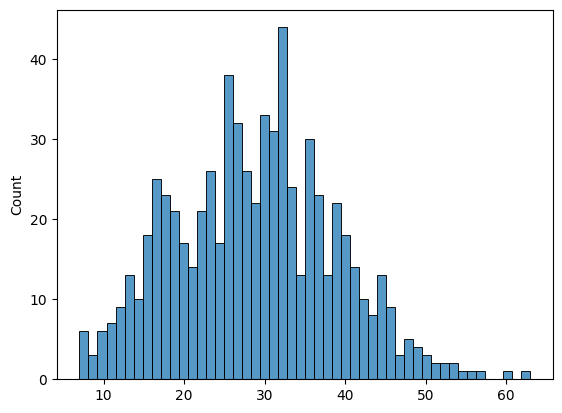

In [149]:
sns.histplot(data = df_filtrado, x = "skin_thickness", bins = 50).set(xlabel = None)

[Text(0.5, 0, '')]

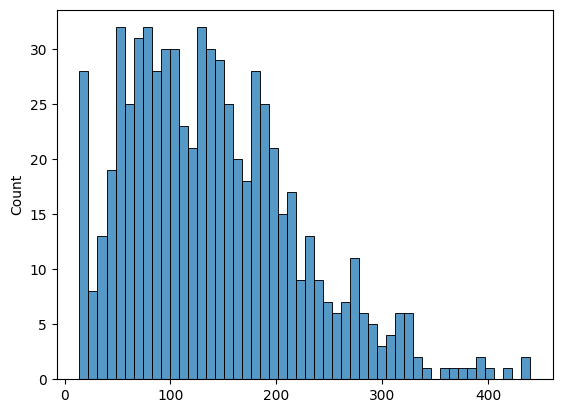

In [150]:
# Imputamos los datos de la columna insulin

mu_ins = df_sin_ceros["insulin"].mean()
sigma_ins = df_sin_ceros["insulin"].std()
num_zeros_ins = (df_filtrado["insulin"] == 0).sum()
random_values = np.random.normal(mu_ins, sigma_ins, num_zeros_ins)
random_values = np.clip(random_values, a_min=df_sin_ceros["insulin"].min(), a_max=df_sin_ceros["insulin"].max())
df_filtrado.loc[df_filtrado["insulin"] == 0, "insulin"] = random_values
sns.histplot(data = df_filtrado, x = "insulin", bins = 50).set(xlabel = None)

In [151]:
df_filtrado.describe()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,outcome
count,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000
mean,3.867153,120.929927,73.027737,28.707168,140.173280,32.263504,0.467724,33.383942,0.332847
std,3.291605,30.038198,11.557919,9.951765,80.613033,6.692080,0.316396,11.747342,0.471577
min,0.000000,56.000000,50.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,21.417021,76.737331,27.400000,0.245000,24.000000,0.000000
50%,3.000000,116.000000,72.000000,29.000000,130.000000,32.000000,0.370000,29.000000,0.000000
75%,6.000000,140.000000,80.000000,35.324746,189.788074,36.400000,0.626000,41.000000,1.000000
max,13.000000,199.000000,122.000000,63.000000,440.000000,59.400000,2.420000,81.000000,1.000000


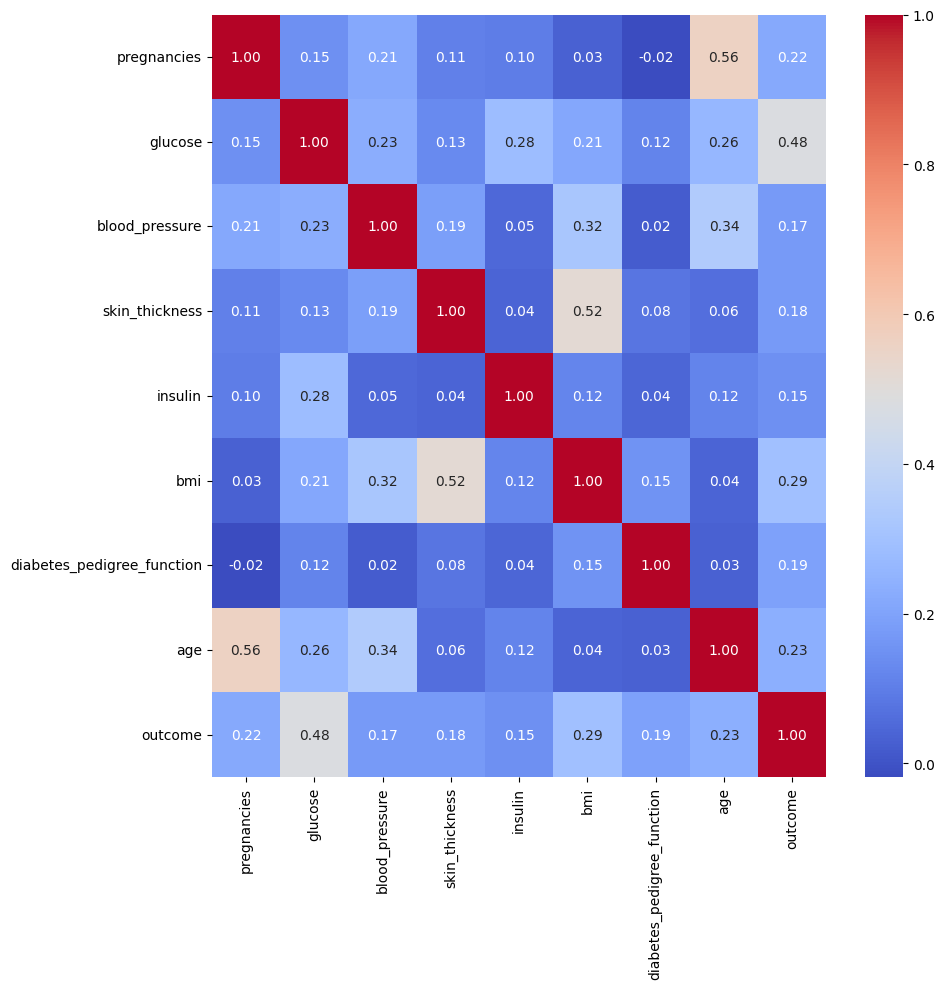

In [152]:
fig, axis = plt.subplots(figsize = (10, 10))

sns.heatmap(df_filtrado.corr(), annot = True, fmt = ".2f", cmap = "coolwarm")

plt.tight_layout()

plt.show()

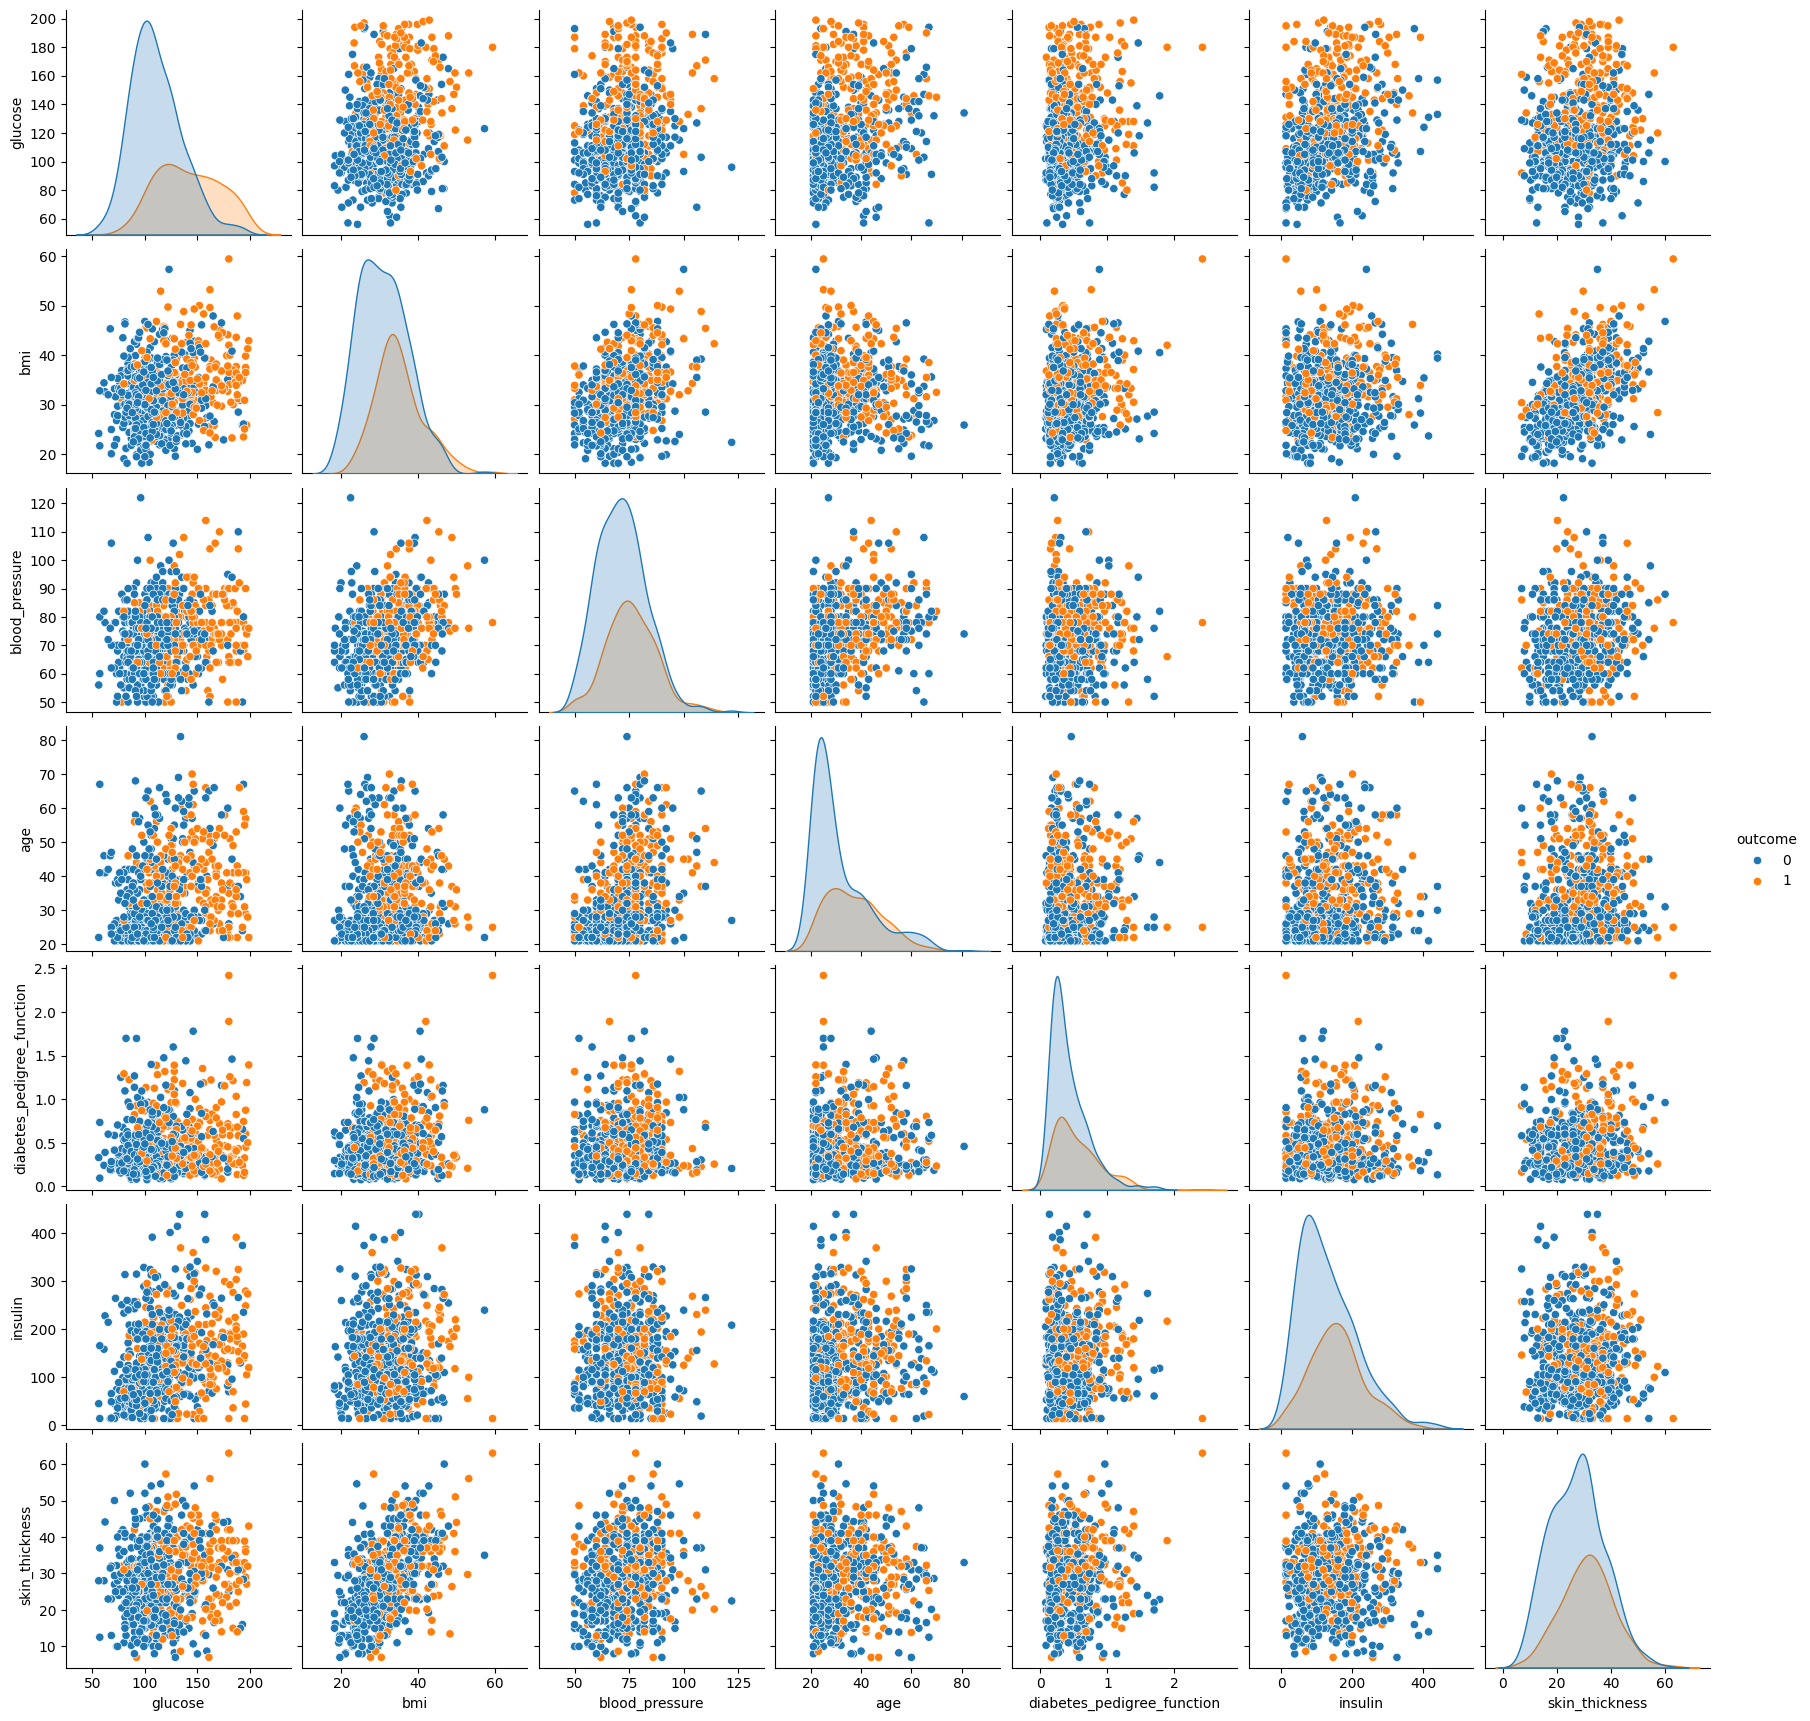

In [153]:
sns.pairplot(df_filtrado, hue='outcome', vars=['glucose', 'bmi', 'blood_pressure', 'age', 'diabetes_pedigree_function', 'insulin', 'skin_thickness'])
plt.show()

## Split

In [181]:
X = df_filtrado.drop(["outcome", "pregnancies"], axis = 1)
y = df_filtrado["outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [182]:
X_train.shape, X_test.shape

((548, 7), (137, 7))

In [183]:
# instancio el escalador
num_variables = [#"pregnancies", 
                 "glucose", 
                 "blood_pressure", 
                 "skin_thickness", 
                 "insulin", 
                 "bmi", 
                 "diabetes_pedigree_function", 
                 "age"]
scaler = StandardScaler()

# entreno el escalador con los datos de entrenamiento
scaler.fit(X_train[num_variables])

# aplico el escalador en ambos
X_train_final = scaler.transform(X_train[num_variables])
X_train_final = pd.DataFrame(X_train_final, index = X_train.index, columns = num_variables)

X_test_final = scaler.transform(X_test[num_variables])
X_test_final = pd.DataFrame(X_test_final, index = X_test.index, columns = num_variables)

X_train_final.head()

,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age
623,-0.907532,-0.249899,-0.157758,-0.303183,1.717181,-0.400924,-1.068348
636,-0.575249,0.103279,0.539660,-0.576938,-0.529737,-1.023641,1.235584
544,-1.106902,0.456457,0.049366,-0.784091,-0.040612,-0.343147,-0.385702
238,1.418447,0.986224,-0.779132,0.900357,-0.224034,1.152657,-0.129709
258,2.382067,-2.015789,-1.296943,2.902874,-0.973006,0.587718,-0.812356


In [184]:
# Por último, guardamos los datos en formato .csv en la carpeta correspondiente
X_train_final.to_csv("../data/processed/X_train.csv", index=False)
X_test_final.to_csv("../data/processed/X_test.csv", index=False)
y_train.to_csv("../data/processed/y_train.csv", index=False)
y_test.to_csv("../data/processed/y_test.csv", index=False)

In [185]:
# modelo
model = DecisionTreeClassifier(random_state = 42, max_depth = 4)

# entrenamiento
model.fit(X_train_final, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


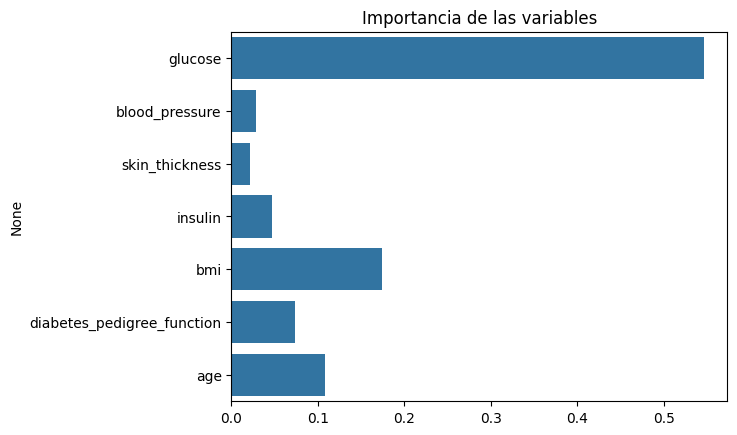

In [186]:
importances = model.feature_importances_
sns.barplot(x=importances, y=X.columns)
plt.title("Importancia de las variables")
plt.show()

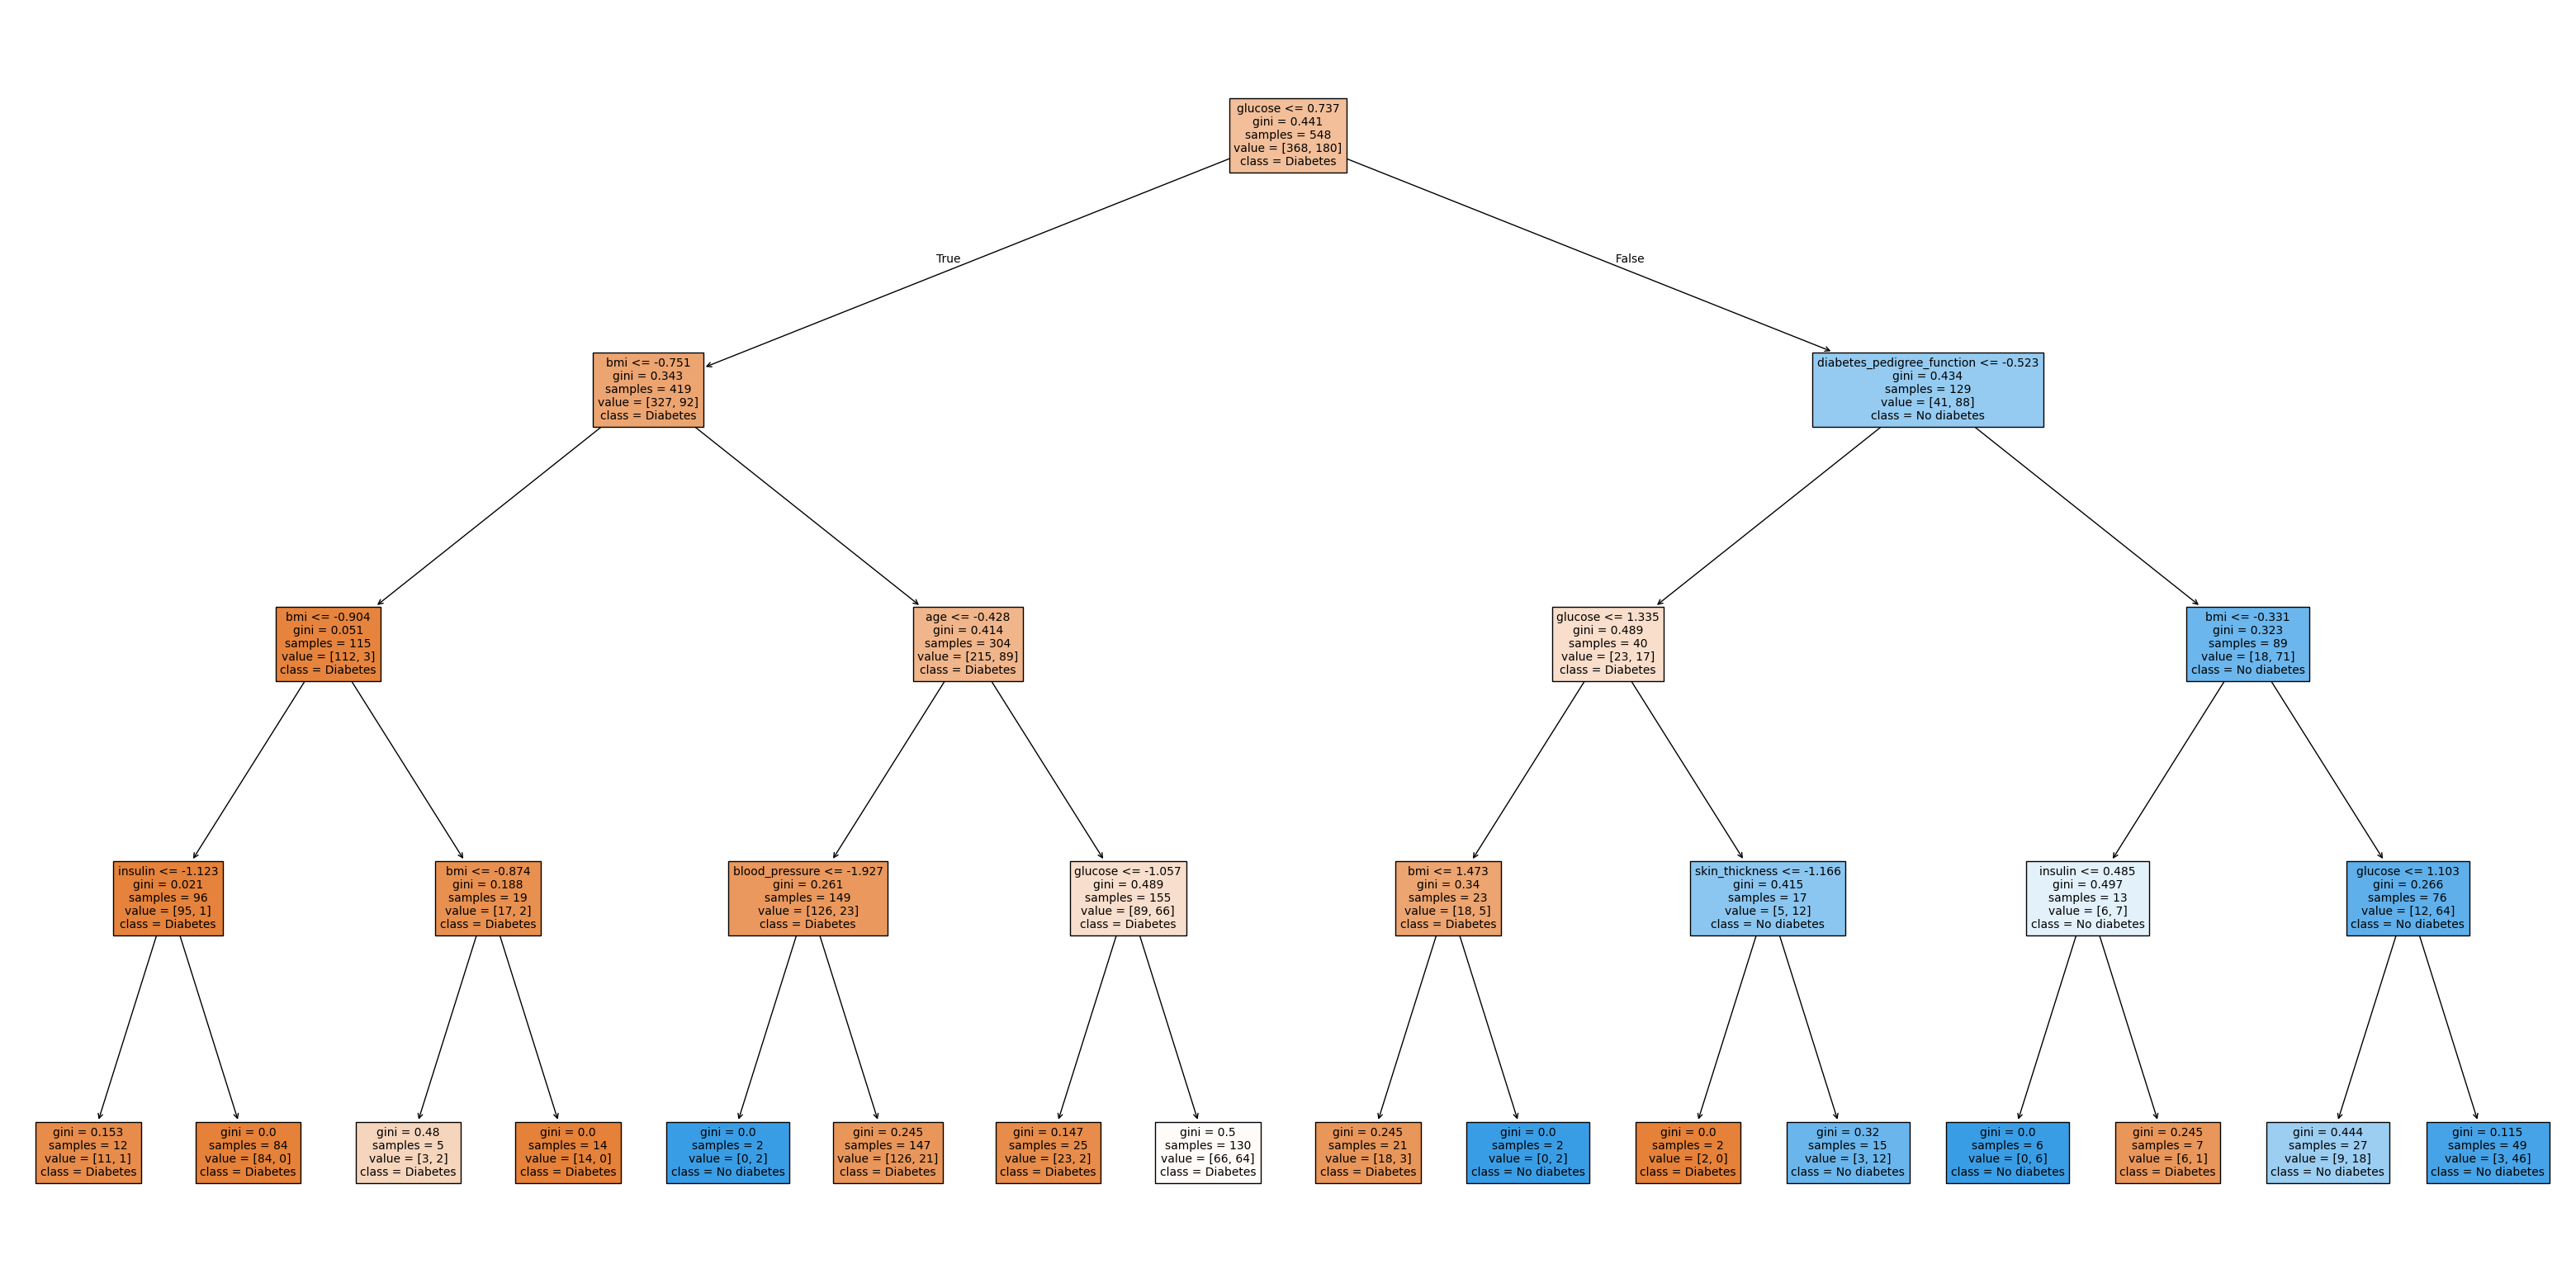

In [187]:
fig = plt.figure(figsize=(40,20))

tree.plot_tree(model, feature_names = list(X_train_final.columns), class_names = ["Diabetes", "No diabetes"], filled = True, fontsize=10)

plt.show()

In [188]:
# predicción
y_pred_test = model.predict(X_test_final)
y_pred_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0])

In [189]:
y_pred_train = model.predict(X_train_final)
y_pred_train

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,

In [190]:
# metricas
accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_train = accuracy_score(y_train, y_pred_train)

f1_score_test = f1_score(y_test, y_pred_test)
f1_score_train = f1_score(y_train, y_pred_train)

precision_test = precision_score(y_test, y_pred_test)
precision_train = precision_score(y_train, y_pred_train)

recall_test = recall_score(y_test, y_pred_test)
recall_train = recall_score(y_train, y_pred_train)

print("Accuracy Test: ", accuracy_test)
print("F1 score Test: ", f1_score_test)
print("Precision Test: ", precision_test)
print("Recall Test: ", recall_test)

print("Accuracy Train: ", accuracy_train)
print("F1 score Train: ", f1_score_train)
print("Precision Train: ", precision_train)
print("Recall Train: ", recall_train)


Accuracy Test:  0.7226277372262774
F1 score Test:  0.4722222222222222
Precision Test:  0.7083333333333334
Recall Test:  0.3541666666666667
Accuracy Train:  0.801094890510949
F1 score Train:  0.6120996441281139
Precision Train:  0.8514851485148515
Recall Train:  0.4777777777777778


In [192]:
print(classification_report(y_test, y_pred_test, target_names=["Diabetes", "No diabetes"]))

              precision    recall  f1-score   support

    Diabetes       0.73      0.92      0.81        89
 No diabetes       0.71      0.35      0.47        48

    accuracy                           0.72       137
   macro avg       0.72      0.64      0.64       137
weighted avg       0.72      0.72      0.69       137



Este modelo detecta muy bien los casos de diabetes (recall: 0.92), con algunos falsos positivos (precision: 0.73)
Sin embargo tiene problemas detectando correctamente los casos de no diabetes (recall: 0.35).
Esto es posiblemente debido a que la clase Diabetes tiene más muestras.

In [193]:
# modelo
model2 = DecisionTreeClassifier(random_state = 42, max_depth = 4, class_weight="balanced")

# entrenamiento
model2.fit(X_train_final, y_train)

# predicción
y_pred_test2 = model2.predict(X_test_final)
y_pred_train2 = model2.predict(X_train_final)


# metricas
accuracy_test = accuracy_score(y_test, y_pred_test2)
accuracy_train = accuracy_score(y_train, y_pred_train2)

f1_score_test = f1_score(y_test, y_pred_test2)
f1_score_train = f1_score(y_train, y_pred_train2)

precision_test = precision_score(y_test, y_pred_test2)
precision_train = precision_score(y_train, y_pred_train2)

recall_test = recall_score(y_test, y_pred_test2)
recall_train = recall_score(y_train, y_pred_train2)

print("Accuracy Test: ", accuracy_test)
print("F1 score Test: ", f1_score_test)
print("Precision Test: ", precision_test)
print("Recall Test: ", recall_test)

print("Accuracy Train: ", accuracy_train)
print("F1 score Train: ", f1_score_train)
print("Precision Train: ", precision_train)
print("Recall Train: ", recall_train)


print(classification_report(y_test, y_pred_test2, target_names=["Diabetes", "No diabetes"]))

Accuracy Test:  0.6934306569343066
F1 score Test:  0.5882352941176471
Precision Test:  0.5555555555555556
Recall Test:  0.625
Accuracy Train:  0.7883211678832117
F1 score Train:  0.7184466019417476
Precision Train:  0.6379310344827587
Recall Train:  0.8222222222222222
              precision    recall  f1-score   support

    Diabetes       0.78      0.73      0.76        89
 No diabetes       0.56      0.62      0.59        48

    accuracy                           0.69       137
   macro avg       0.67      0.68      0.67       137
weighted avg       0.70      0.69      0.70       137



Al volver a entrenar un segundo modelo con max_depth=4 y class_weight="balanced", observamos:

Sigue detectando bien la clase Diabetes (recall 0.73) y mejora la precisión (0.78), reduciendo falsos positivos.

La clase No diabetes, que antes era difícil de detectar (recall 0.35), ahora mejora (recall 0.62).

El accuracy disminuye ligeramente (0.72 a 0.69), pero el modelo trata de manera más justa a ambas clases, reduciendo sesgos hacia la clase mayoritaria.

In [194]:
# Guardar el modelo
with open("../models/decision_tree_classifier_classweight_balanced.sav", "wb") as f:
    pickle.dump(model2, f)

# Modelo Random Forest

In [195]:
# modelo
# default n_estimators=100
model3 = RandomForestClassifier(random_state = 42, max_depth = 6)

# entrenamiento
model3.fit(X_train_final, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


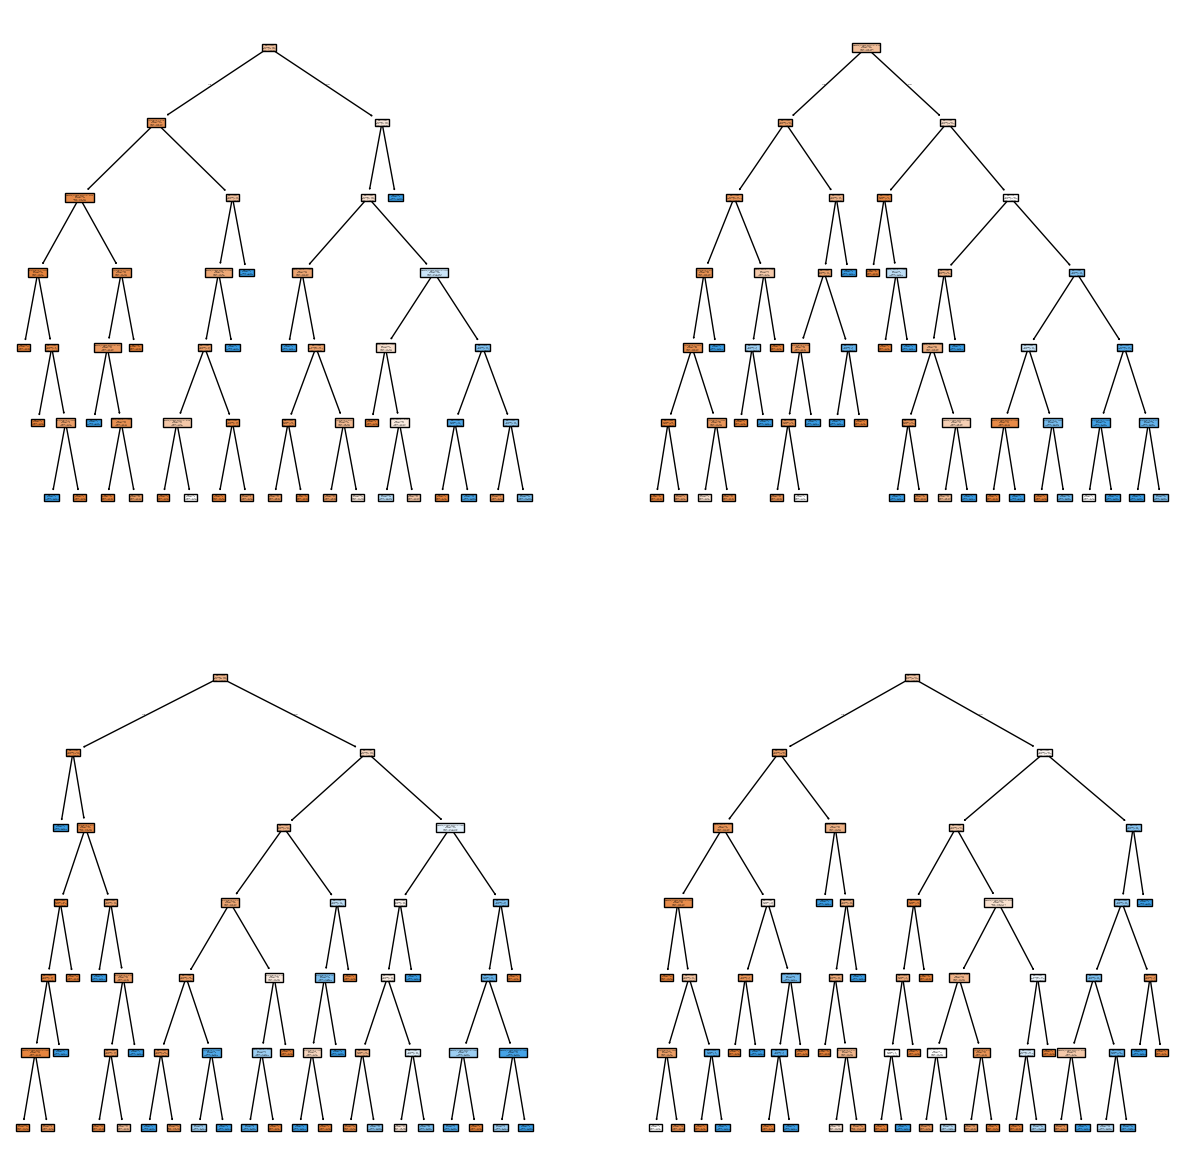

In [196]:
fig, axis = plt.subplots(2, 2, figsize = (15, 15))

# Mostramos los 4 primeros árboles de los 100 generados (por defecto)
clases = ["Diabetes", "No diabetes"]
tree.plot_tree(model3.estimators_[0], ax = axis[0, 0], feature_names = list(X_train_final.columns), class_names = clases, filled = True)
tree.plot_tree(model3.estimators_[1], ax = axis[0, 1], feature_names = list(X_train_final.columns), class_names = clases, filled = True)
tree.plot_tree(model3.estimators_[2], ax = axis[1, 0], feature_names = list(X_train_final.columns), class_names = clases, filled = True)
tree.plot_tree(model3.estimators_[3], ax = axis[1, 1], feature_names = list(X_train_final.columns), class_names = clases, filled = True)

plt.show()

In [197]:
# predicción
y_pred_test3 = model3.predict(X_test_final)
y_pred_test3

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0])

In [198]:
y_pred_train3 = model3.predict(X_train_final)
y_pred_train3

array([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,

In [199]:
# metricas
accuracy_test = accuracy_score(y_test, y_pred_test3)
accuracy_train = accuracy_score(y_train, y_pred_train3)

f1_score_test = f1_score(y_test, y_pred_test3)
f1_score_train = f1_score(y_train, y_pred_train3)

precision_test = precision_score(y_test, y_pred_test3)
precision_train = precision_score(y_train, y_pred_train3)

recall_test = recall_score(y_test, y_pred_test3)
recall_train = recall_score(y_train, y_pred_train3)

print("Accuracy Test: ", accuracy_test)
print("F1 score Test: ", f1_score_test)
print("Precision Test: ", precision_test)
print("Recall Test: ", recall_test)

print("Accuracy Train: ", accuracy_train)
print("F1 score Train: ", f1_score_train)
print("Precision Train: ", precision_train)
print("Recall Train: ", recall_train)

print(classification_report(y_test, y_pred_test3, target_names=["Diabetes", "No diabetes"]))

Accuracy Test:  0.7664233576642335
F1 score Test:  0.5897435897435898
Precision Test:  0.7666666666666667
Recall Test:  0.4791666666666667
Accuracy Train:  0.8941605839416058
F1 score Train:  0.8198757763975155
Precision Train:  0.9295774647887324
Recall Train:  0.7333333333333333
              precision    recall  f1-score   support

    Diabetes       0.77      0.92      0.84        89
 No diabetes       0.77      0.48      0.59        48

    accuracy                           0.77       137
   macro avg       0.77      0.70      0.71       137
weighted avg       0.77      0.77      0.75       137



In [172]:
# Guardar el modelo
with open("../models/random_forest_classifier_maxdepth_6.sav", "wb") as f:
    pickle.dump(model3, f)

Buen rendimiento en Diabetes (recall 0.92 y F1 0.84)
Y sube en accuracy (0.77) frente a los modelos de Decision Tree



In [201]:
# modelo
# modificando hiperparametros
model4 = RandomForestClassifier(random_state = 42, max_depth = 6, n_estimators = 50)

# entrenamiento
model4.fit(X_train_final, y_train)

,n_estimators,50
,criterion,'gini'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [202]:
# predicción
y_pred_test4 = model4.predict(X_test_final)
y_pred_train4 = model4.predict(X_train_final)
# metricas
accuracy_test = accuracy_score(y_test, y_pred_test4)
accuracy_train = accuracy_score(y_train, y_pred_train4)

f1_score_test = f1_score(y_test, y_pred_test4)
f1_score_train = f1_score(y_train, y_pred_train4)

precision_test = precision_score(y_test, y_pred_test4)
precision_train = precision_score(y_train, y_pred_train4)

recall_test = recall_score(y_test, y_pred_test4)
recall_train = recall_score(y_train, y_pred_train4)

print("Accuracy Test: ", accuracy_test)
print("F1 score Test: ", f1_score_test)
print("Precision Test: ", precision_test)
print("Recall Test: ", recall_test)

print("Accuracy Train: ", accuracy_train)
print("F1 score Train: ", f1_score_train)
print("Precision Train: ", precision_train)
print("Recall Train: ", recall_train)

print(classification_report(y_test, y_pred_test4, target_names=["Diabetes", "No diabetes"]))


Accuracy Test:  0.7737226277372263
F1 score Test:  0.6075949367088608
Precision Test:  0.7741935483870968
Recall Test:  0.5
Accuracy Train:  0.8959854014598541
F1 score Train:  0.8256880733944955
Precision Train:  0.9183673469387755
Recall Train:  0.75
              precision    recall  f1-score   support

    Diabetes       0.77      0.92      0.84        89
 No diabetes       0.77      0.50      0.61        48

    accuracy                           0.77       137
   macro avg       0.77      0.71      0.72       137
weighted avg       0.77      0.77      0.76       137



In [203]:
# Guardar el modelo
with open("../models/random_forest_classifier_n_estimators_50.sav", "wb") as f:
    pickle.dump(model4, f)

Al modificar el número de árboles generados en el modelo, no se observaron mejoras en las métricas.
El modelo mantiene un accuracy del 77 % 

Tras probar varios modelos basados en Decision Trees y Random Forests, se observó que los modelos de Random Forest alcanzaron una exactitud del 77 %, superando a los árboles de decisión individuales. Aumentar el número de árboles no produjo mejoras, lo que sugiere que el modelo ya ha alcanzado un punto de estabilidad

# Boosting

In [204]:
ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state = 42, use_label_encoder=False, eval_metric='mlogloss')


# entrenamiento

ada.fit(X_train_final, y_train)
gb.fit(X_train_final, y_train)
xgb.fit(X_train_final, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [205]:
# predicción
ada_y_pred_test = ada.predict(X_test_final)
gb_y_pred_test = gb.predict(X_test_final)
xgb_y_pred_test = xgb.predict(X_test_final)

ada_y_pred_train = ada.predict(X_train_final)
gb_y_pred_train = gb.predict(X_train_final)
xgb_y_pred_train = xgb.predict(X_train_final)

In [206]:
# métricas

ada_accuracy_test = accuracy_score(y_test, ada_y_pred_test)
ada_accuracy_train = accuracy_score(y_train, ada_y_pred_train)

gb_accuracy_test = accuracy_score(y_test, gb_y_pred_test)
gb_accuracy_train = accuracy_score(y_train, gb_y_pred_train)

xgb_accuracy_test = accuracy_score(y_test, xgb_y_pred_test)
xgb_accuracy_train = accuracy_score(y_train, xgb_y_pred_train)

print('AdaBoost')
print("Accuracy Test: ", ada_accuracy_test)
print("Accuracy Train: ", ada_accuracy_train)

print('Gradient Boosting')
print("Accuracy Test: ", gb_accuracy_test)
print("Accuracy Train: ", gb_accuracy_train)

print('XGBoost')
print("Accuracy Test: ", xgb_accuracy_test)
print("Accuracy Train: ", xgb_accuracy_train)

AdaBoost
Accuracy Test:  0.7372262773722628
Accuracy Train:  0.7645985401459854
Gradient Boosting
Accuracy Test:  0.7372262773722628
Accuracy Train:  0.9434306569343066
XGBoost
Accuracy Test:  0.7445255474452555
Accuracy Train:  0.9927007299270073


Con AdaBoost tenemos unas predicciones de test y train bastante balanceadas, pero el accuracy puede que sea algo bajo y exista un ligero underfitting.
Con Gradient Boosting tenemos un buen test pero con un riesgo de overfitting
Con XGBoost tenemos un test bueno pero hay un claro overfitting

Por ahora, Random Forest o XGBoost regularizado parecen los mejores candidatos.

### Regularización de XGBoost

In [219]:
xgb2 = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth = 4, random_state = 42, use_label_encoder=False, eval_metric='mlogloss')
xgb2.fit(X_train_final, y_train)
xgb2_y_pred_test = xgb2.predict(X_test_final)
xgb2_y_pred_train = xgb2.predict(X_train_final)

In [220]:
xgb2_accuracy_test = accuracy_score(y_test, xgb2_y_pred_test)
xgb2_accuracy_train = accuracy_score(y_train, xgb2_y_pred_train)

print('XGBoost')
print("Accuracy Test: ", xgb2_accuracy_test)
print("Accuracy Train: ", xgb2_accuracy_train)

XGBoost
Accuracy Test:  0.7518248175182481
Accuracy Train:  0.9142335766423357


In [221]:
# Guardar el modelo
with open("../models/XGBoost_classifier_learning_rate_05_max_depth_4.sav", "wb") as f:
    pickle.dump(xgb2, f)

Con la modificación de hiperparametros hemos conseguido reducir el overfitting sin perder capacidad predictiva

En conjunto, Random Forest y XGBoost fueron los modelos con mejor desempeño general. Random Forest es el modelo que ofrece mayor equilibrio entre train y test. No muesta tanto sobreajuste como el modelo de XGBoost.